# Определение стоимости автомобилей

Описание проекта:

- Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Цели и задачи проекта:
- Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


Признаки:

- date_crawled — дата скачивания анкеты из базы
- vehicle_type — тип автомобильного кузова
- registration_year — год регистрации автомобиля
- gearbox — тип коробки передач
- power — мощность (л. с.)
- model — модель автомобиля
- kilometer — пробег (км)
- registration_month — месяц регистрации автомобиля
- fuel_type — тип топлива
- brand — марка автомобиля
- repaired — была машина в ремонте или нет
- date_created — дата создания анкеты
- number_of_pictures — количество фотографий автомобиля
- postal_code — почтовый индекс владельца анкеты (пользователя)
- last_seen — дата последней активности пользователя

Целевой признак:

- Price — цена (евро)


Примечания:

Для оценки качества моделей применяется метрика RMSE.
Значение метрики RMSE должно быть меньше 2500.
Изучается библиотека LightGBM и её средствами строятся  модели градиентного бустинга.


## Подготовка данных

In [1]:
#%pip install --upgrade pip

In [2]:
#%pip install sklearn

In [3]:
#%pip install seaborn

In [4]:
#%pip show scikit-learn
#%pip install -U scikit-learn

In [5]:
# загрузим потенциально необходимые библиотеки,пакеты и классы.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

#!pip install pandas-profiling[notebook]
#import pandas_profiling
#from pandas_profiling import ProfileReport

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from tqdm.notebook import tqdm


from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder

import time

from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

#1001
#from sklearn.preprocessing import OrdinalEncoder

# константы 
RANDOM_STATE = 42

print("ok")

ok


In [6]:
#загрузим данные

# df = pd.read_csv('/datasets/autos.csv')
    #df = pd.read_csv('./autos.csv')
# except:
#     print("Есть ошибки")
# else:
#     print("Все загрузилось!")

try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

df.head()  

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
#profile = ProfileReport(df, title="Не бит, не крашен")
#запускаем показ профиля
#profile

In [8]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Из сформированного Отчета (ProfileReport) можно  выделить основные характеристики данных:

- Средняя стоимость авто 2900 евро, минимальная -11, максимальная - 20000.
- Минимальный год регистриции автомобиля 1000, максимальный - 9999. 
- Максимальное значение в мощности автомобиля в лошадинных силах - 20 000, минимальное- 0.
- Минимальный пробег авто 5000, максимальный - 150000.
- Есть дубликаты: 4 (< 0.1%) 


- 8 уникальных типов автомобильного кузова:

- sedan	97627	29.7%
- small	86438	26.3%
- wagon	66247	20.2%
- bus	30886	 9.4%
- conv  18667	 5.7%
- coupe	14211	 4.3%
- suv	11664	 3.6%
- other	2681	 0.8%


- Чаще встречаются авто с ручной коробкой передач и с бензиновым двигателем:

- petrol	    222042	67.6%
- gasoline	    100446	30.6%
- lpg	          4980	 1.5%
- cng	           543	 0.2%
- hybrid	       226	 0.1%
- other	           103	 < 0.1%
- electric	        81	 < 0.1%


- Самые популярные бренды:

- volks   70320	21.4%
- opel	37574	11.4%
- bmw	    34431	10.5%
- merc	28743	8.8%
- audi	27467	8.4%
- ford	23807	7.2%
- renault	17183	5.2%
- peugeot	10656	3.2%
- fiat	8978	2.7%
- seat	6680	2.0%
- Other 	62582	19.1%


Объем пропущенных значений:

- gearbox  16857 (4.9%)
- model 17219 (5.6%) 
- vehicle_type 37490 (10%)
- fuel_type  28899 (8.4%) 
- repaired  65082 (19%)


Высокая корреляция у price:

- registration_year
- power
- vehicle_type

In [9]:
#info
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Краткие выводы:

- В столбце Price  есть аномальные цены (минимальная цена 0)
- В столбце registration_year есть некорректные значения года регистрации (1000)
- В столбце power есть некорректные значения мощности двигателя (2000/0).
- В столбце registration_month отсутсвует месяц регистрации.
- В столбце number_of_pictures нет данных (0).

Посмотрим на данные значимых столбцов, влияющих на стоимость и скорректируем там, где будет необходимо(заменим/ удалим)

- vehicle_type
- gearbox
- power
- kilometer
- fuel_type
- brand
- repaired
- registration_year
- model

И на данные менее значимых столбцов:

- date_crawled — дата скачивания анкеты из базы
- registration_month — месяц регистрации автомобиля
- date_created — дата создания анкеты
- number_of_pictures — количество фотографий автомобиля
- postal_code — почтовый индекс владельца анкеты (пользователя)
- last_seen — дата последней активности пользователя

In [10]:
# выведем список наименований столбцов в датафрейме
df.columns.values.tolist ()

['DateCrawled',
 'Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'Repaired',
 'DateCreated',
 'NumberOfPictures',
 'PostalCode',
 'LastSeen']

In [11]:
#преобразуем строки из "верблюжьего" регистра в "змеиный"
camel_to_snake = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower() for col in df.columns]

In [12]:
df.columns = camel_to_snake

In [13]:
# выведем список преобразованных столбцов в датафрейме
df.columns.values.tolist ()

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

In [14]:
# выведем пропущенные значения в таблицу
df.isna().agg(['sum', 'mean']).T

,sum,mean
date_crawled,0.0,0.000000
price,0.0,0.000000
vehicle_type,37490.0,0.105794
registration_year,0.0,0.000000
gearbox,19833.0,0.055967
power,0.0,0.000000
model,19705.0,0.055606
kilometer,0.0,0.000000
registration_month,0.0,0.000000
fuel_type,32895.0,0.092827


In [15]:
#удалим малоинформативные данные
df = df.drop(["date_crawled", "date_created", "last_seen","number_of_pictures","postal_code","registration_month"], axis=1) 

**Проанализируем данные целевого признака = Price — цена (Евро), избавимся от некорректных данных**

Судя по данным автомобильных информационных ресурсов, например, www.mobile.de/, www.autoscout24.de/ минимальная адекватная рынку цена поддержанного автомобиля начинается от 1000 евро.

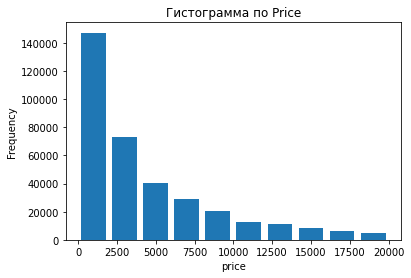

In [16]:
# построим гистограмму по столбцу price
df['price'].plot(kind='hist', rwidth=0.8)
plt.title("Гистограмма по Price")
plt.xlabel("price")
plt.show()

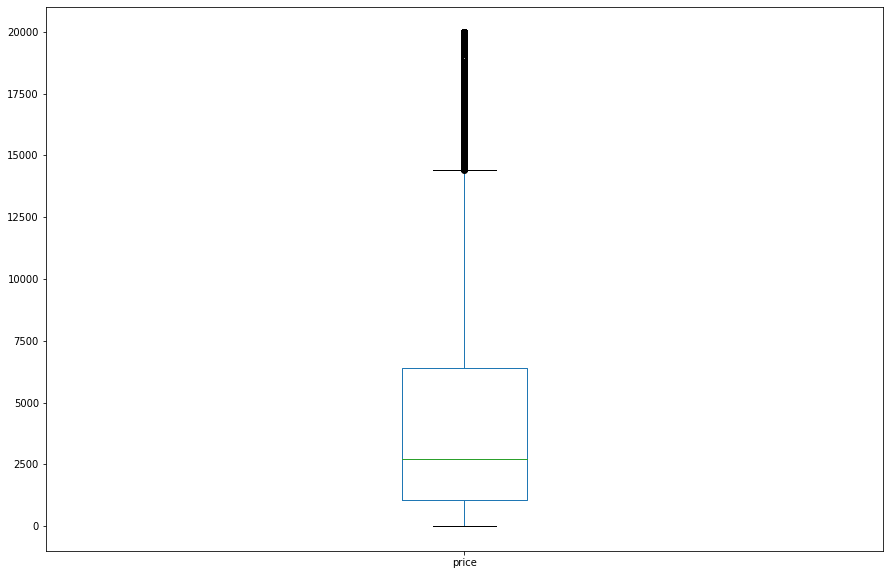

<Figure size 2160x2160 with 0 Axes>

In [17]:
# построим диаграмму размаха по столбцу price

df['price'].plot(kind='box', figsize=(15, 10))

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.figure(figsize=(30, 30))

plt.show()


In [18]:
# минимальная и максимальная цена
print('price' + str(df['price'].min()))
print('price' + str(df['price'].max()))

price0
price20000


In [ ]:
print(f'price {df["price"].min()}')

In [20]:
df = df[df.price > 1000]

In [21]:
#после фильтрации
df.price.describe()

count    266394.000000
mean       5699.998416
std        4520.785920
min        1001.000000
25%        2200.000000
50%        4000.000000
75%        7950.000000
max       20000.000000
Name: price, dtype: float64

In [22]:
#info
df.vehicle_type.describe()

count     246832
unique         8
top        sedan
freq       73048
Name: vehicle_type, dtype: object

In [23]:
# предобработка данных: выведем уникальные значения в столбике
print(df.vehicle_type.unique())

['coupe' 'suv' 'small' 'convertible' 'bus' 'sedan' 'wagon' nan 'other']


In [24]:
# Предобработка данных: поменяем значение nan
df['vehicle_type'] = df['vehicle_type'].fillna('other')
print(df.vehicle_type.unique())

['coupe' 'suv' 'small' 'convertible' 'bus' 'sedan' 'wagon' 'other']


In [25]:
#info
df.gearbox.describe()

count     256576
unique         2
top       manual
freq      197853
Name: gearbox, dtype: object

In [26]:
# предобработка данных: избавимся от  пропущенных данных
print(df.gearbox.unique())
df.dropna(subset=['gearbox'], inplace=True)
print(df.gearbox.unique())

['manual' 'auto' nan]
['manual' 'auto']


In [27]:
#info
df.gearbox.describe()

count     256576
unique         2
top       manual
freq      197853
Name: gearbox, dtype: object

In [28]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [29]:
# предобработка данных: фильтрация данных в столбце
print(df["registration_year"].count())
df=df.query('registration_year >= 1960 & registration_year < 2017')
print(df["registration_year"].count())

256576
247141


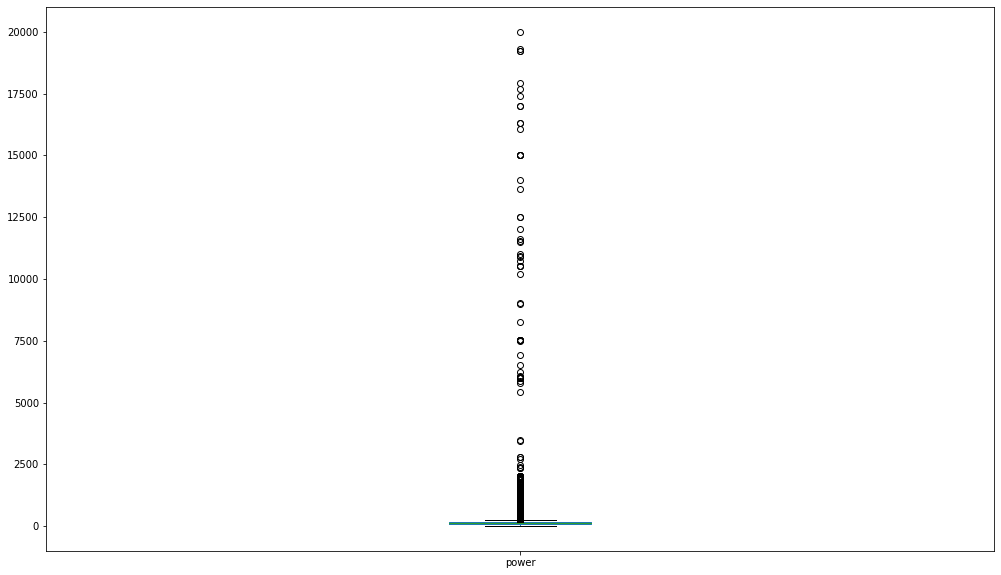

<Figure size 2160x2160 with 0 Axes>

In [30]:
#столбец power: рассмотрим  для дальнейшего анализа автомобили можностью от 70 л.с. до  250л.с. 
    
df['power'].plot(kind='box', figsize=(17, 10))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.figure(figsize=(30, 30))

plt.show()

In [31]:
# предобработка данных: отфильтруем значение "power" 
print(df["power"].count())
df = df.query('power <= 250')
print(df["power"].count())

247141
240393


In [ ]:
df = df.query('70 <= power <=250')

In [ ]:
df.describe()

In [ ]:
    
df['power'].plot(kind='box', figsize=(17, 10))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.figure(figsize=(30, 30))

plt.show()

In [35]:
# предобработка данных: удаляем  пропуски
print(df['model'].isna().sum())

df.dropna(subset=['model'], inplace=True)
print(df['model'].isna().sum())

5771
0


In [36]:
# предобработка данных: замена Nan на "other"
print(df['fuel_type'].unique())

df['fuel_type']=df['fuel_type'].fillna('other')
print(df['fuel_type'].unique())

['gasoline' 'petrol' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
['gasoline' 'petrol' 'other' 'lpg' 'hybrid' 'cng' 'electric']


In [37]:
# предобработка данных, замена 0 на Nan для дальнейшей замены на среднее значение
df['power'] = df['power'].replace(0, np.NaN)

In [38]:
# предобработка данных:заменим пропущенные значения в столбце на наиболее вероятное 
print(df.repaired.unique())

df["repaired"] = df["repaired"].fillna("no")
print(df.repaired.unique())

[nan 'no' 'yes']
['no' 'yes']


In [39]:
#df['Repaired'].plot(kind='hist', rwidth=0.8)
print('yes = ', df.query('repaired == "yes"')['repaired'].count())
print('no = ', df.query('repaired == "no"')['repaired'].count())

yes =  11865
no =  184109


In [40]:
#заменим repaired на булев тип
df['repaired'] = df['repaired'].map({'yes':1, 'no':0})
print(df.repaired.unique())

[0 1]


In [41]:
#Проверка данных на NaN

print(df['price'].isna().sum())
print(df['vehicle_type'].isna().sum())
print(df['registration_year'].isna().sum())
print(df['gearbox'].isna().sum())
print(df['power'].isna().sum())
print(df['model'].isna().sum())
print(df['kilometer'].isna().sum())
print(df['fuel_type'].isna().sum())
print(df['brand'].isna().sum())
print(df['repaired'].isna().sum())

0
0
0
0
0
0
0
0
0
0


In [42]:
#Определение количества группировок для более точного рачета мощности внутри группировки
print(      "brand,   model,   fuel_type,   gearbox,   registration_year= ", \
df.groupby(["brand", "model", "fuel_type", "gearbox", "registration_year"])["power"].sum().count())

print(      "brand,   model,   fuel_type,               registration_year= ", \
df.groupby(["brand", "model", "fuel_type",             "registration_year"])["power"].sum().count())

print(      "brand,   model,                gearbox,   registration_year= ", \
df.groupby(["brand", "model",              "gearbox", "registration_year"])["power"].sum().count())

print(      "brand,   model,   registration_year= ", \
df.groupby(["brand", "model", "registration_year"])["power"].sum().count())

print(      "brand,   model,   fuel_type,   gearbox= ", \
df.groupby(["brand", "model", "fuel_type", "gearbox", ])["power"].sum().count())

print(      "brand,   model,   fuel_type= ", \
df.groupby(["brand", "model", "fuel_type"])["power"].sum().count())

print(      "brand,  model,   gearbox= ", \
df.groupby(["brand","model", "gearbox"])["power"].sum().count())

print(      "brand,   model= ", \
df.groupby(["brand", "model"])["power"].sum().count())

print(      "brand=", \
df.groupby(["brand"])["power"].sum().count())

brand,   model,   fuel_type,   gearbox,   registration_year=  13425
brand,   model,   fuel_type,               registration_year=  9808
brand,   model,                gearbox,   registration_year=  7330
brand,   model,   registration_year=  4820
brand,   model,   fuel_type,   gearbox=  1694
brand,   model,   fuel_type=  1047
brand,  model,   gearbox=  539
brand,   model=  288
brand= 38


In [43]:
# предобработка данных: заполним значения в "power"  средним значением по"brand"
df["power"] = df.groupby(["brand", "model", "fuel_type", "gearbox", "registration_year"])["power"].transform(lambda x: x.fillna(x.mean()))
df["power"] = df.groupby(["brand", "model", "fuel_type", "registration_year"])["power"].transform(lambda x: x.fillna(x.mean()))
df["power"] = df.groupby(["brand", "model", "gearbox", "registration_year"])["power"].transform(lambda x: x.fillna(x.mean()))
df["power"] = df.groupby(["brand", "model", "registration_year"])["power"].transform(lambda x: x.fillna(x.mean()))
df["power"] = df.groupby(["brand", "model", "fuel_type", "gearbox"])["power"].transform(lambda x: x.fillna(x.mean()))
df["power"] = df.groupby(["brand", "model", "fuel_type"])["power"].transform(lambda x: x.fillna(x.mean()))
df["power"] = df.groupby(["brand", "model", "gearbox"])["power"].transform(lambda x: x.fillna(x.mean()))
df["power"] = df.groupby(["brand", "model"])["power"].transform(lambda x: x.fillna(x.mean()))
df["power"] = df.groupby(["brand"])["power"].transform(lambda x: x.fillna(x.mean()))

In [44]:
#контрольная проверка данных на пропуски

print(df['price'].isna().sum())
print(df['vehicle_type'].isna().sum())
print(df['registration_year'].isna().sum())
print(df['gearbox'].isna().sum())
print(df['power'].isna().sum())
print(df['model'].isna().sum())
print(df['kilometer'].isna().sum())
print(df['fuel_type'].isna().sum())
print(df['brand'].isna().sum())
print(df['repaired'].isna().sum())


0
0
0
0
0
0
0
0
0
0


In [ ]:
df.isna().sum()

In [46]:
#info
df.power.describe()

count    195974.000000
mean        132.292947
std          41.051205
min          70.000000
25%         101.000000
50%         125.000000
75%         160.000000
max         250.000000
Name: power, dtype: float64

In [47]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,0
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,0
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,0


In [48]:
# столбик kilometer и brand  оставляем как есть

In [49]:
# проверим наличие дубликатов и удалим 
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

29402
0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166572 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              166572 non-null  int64 
 1   vehicle_type       166572 non-null  object
 2   registration_year  166572 non-null  int64 
 3   gearbox            166572 non-null  object
 4   power              166572 non-null  int64 
 5   model              166572 non-null  object
 6   kilometer          166572 non-null  int64 
 7   fuel_type          166572 non-null  object
 8   brand              166572 non-null  object
 9   repaired           166572 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 14.0+ MB


In [51]:
df.head(2)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0


In [52]:
df.shape

(166572, 10)

***Проанализируем зависимость целевого признака от других  признаков ***

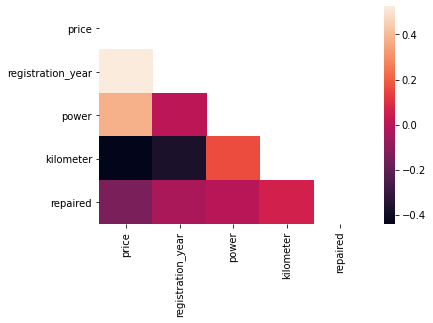

In [53]:
# построим базовый график тепловой карты корреляции

mask = np.triu(np.ones_like(df.corr()))
 
# построим тепловую карту корреляции
dataplot = sns.heatmap(df.corr(), mask=mask)

# выведем на экран
plt.show()   


Корреляция - важнейший фактор, лежащий в основе анализа данных: по графику корреляций  мы можем понять какие переменные в наборе данных связаны друг с другом. Значение корреляции колеблется от -1 до +1. 
- 0 - Корреляция означает, что две переменные не зависят друг от друга,
- положительная корреляция указывает на то, что переменные движутся в одном направлении,
- отрицательная корреляция указывает на противоположное.

In [ ]:
df.describe()

## Обучение моделей

Нам необходимо:
- подготовить выборки для обучения моделей,
- обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры,
- проанализировать время обучения, время предсказания и качество моделей,
- опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

In [55]:
# разделим df на тренировочную и тестовую выборки

for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = df[i].astype('category')
        
features = df.drop(['price'], axis=1)
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

In [56]:
X_train.shape

(124929, 9)

In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124929 entries, 22712 to 249600
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       124929 non-null  category
 1   registration_year  124929 non-null  int64   
 2   gearbox            124929 non-null  category
 3   power              124929 non-null  int64   
 4   model              124929 non-null  category
 5   kilometer          124929 non-null  int64   
 6   fuel_type          124929 non-null  category
 7   brand              124929 non-null  category
 8   repaired           124929 non-null  int64   
dtypes: category(5), int64(4)
memory usage: 5.5 MB


In [58]:
X_test.shape

(41643, 9)

In [59]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41643 entries, 122099 to 292185
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   vehicle_type       41643 non-null  category
 1   registration_year  41643 non-null  int64   
 2   gearbox            41643 non-null  category
 3   power              41643 non-null  int64   
 4   model              41643 non-null  category
 5   kilometer          41643 non-null  int64   
 6   fuel_type          41643 non-null  category
 7   brand              41643 non-null  category
 8   repaired           41643 non-null  int64   
dtypes: category(5), int64(4)
memory usage: 1.8 MB


Мы разбили на выборки,  теперь закодируем и смаштабируем данные.
- Исследуем модели: RandomForestRegressor,LGBMRegressor.
- Метрикой качества моделей является RMSE.

In [60]:
#категориальные признаки для OHE LGBMRegressor
oe_features_rf = X_train.select_dtypes(include='category').columns.to_list()
print(oe_features_rf)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']


In [61]:
#численные признаки: 'repaired' — категориальный(бинарный) признак
num_features = X_train.select_dtypes(exclude='category').columns.to_list()
num_features.remove('repaired')
num_features

['registration_year', 'power', 'kilometer']

In [62]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41643 entries, 122099 to 292185
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   vehicle_type       41643 non-null  category
 1   registration_year  41643 non-null  int64   
 2   gearbox            41643 non-null  category
 3   power              41643 non-null  int64   
 4   model              41643 non-null  category
 5   kilometer          41643 non-null  int64   
 6   fuel_type          41643 non-null  category
 7   brand              41643 non-null  category
 8   repaired           41643 non-null  int64   
dtypes: category(5), int64(4)
memory usage: 1.8 MB


***Исследуем  RandomForestRegressor***

In [63]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [ ]:
col_transformer_rf= make_column_transformer(  
    
    (OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1), 
        oe_features_rf),
    
    (StandardScaler(), num_features),
    remainder="passthrough"
)

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestregressor__n_estimators': range(50, 101, 50),
    'randomforestregressor__max_depth': range(6, 11, 2)
}

gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    cv = KFold(5, shuffle=True, random_state=RANDOM_STATE),
    random_state=RANDOM_STATE,
    verbose=10
)

gs_rf.fit(X_train_rf, y_train)


# время обучения и предсказания

time_fit_rf = gs_rf.cv_results_['mean_fit_time'] [gs_rf.best_index_]
time_predict_rf = gs_rf.cv_results_['mean_score_time'] [gs_rf.best_index_]


print(f'Time Fit = {round(time_fit_rf,2)}sec')
print('*'*50)
print(f'Time Predict ={round(time_predict_rf,2)}sec')
print('*'*50)
print('fit done successfully!')
print('*'*50)
print(f'best_score: {round(-gs_rf.best_score_, 2)}')
print('*'*50)
print(f'best_params: {gs_rf.best_params_}')

***Исследуем LGBMRegressor***

In [ ]:

model_lgb = lgb.LGBMRegressor(random_state=RANDOM_STATE)

hyperparams_lgb = {'max_depth': range(10, 15),
                 'learning_rate': [0.1, 0.2]
                  }

lgb_grid = GridSearchCV(
    model_lgb, 
    param_grid = hyperparams_lgb,
    cv = KFold(5, shuffle=True, random_state=RANDOM_STATE),
    scoring ='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=10
)

lgb_grid.fit(X_train, y_train)

# время обучения и предсказания

time_fit_lgb = lgb_grid.cv_results_['mean_fit_time'] [lgb_grid.best_index_]
time_predict_lgb = lgb_grid.cv_results_['mean_score_time'] [lgb_grid.best_index_]


print(f'Time Fit = {round(time_fit_lgb,2)}sec')
print('*'*50)
print(f'Time Predict = {round(time_predict_lgb,2)}sec')
print('*'*50)
print('fit done successfully!')
print('*'*50)
print(f'best_score: {round(-lgb_grid.best_score_, 2)}')
print('*'*50)
print(f'best_params: {lgb_grid.best_params_}')

***Анализ моделей***

Основные факторы  при выборе модели - следующие показатели:

 - Время обучения
 - Время предсказания
 - Качество предсказаний

Для оценки качества моделей нам необходимо по ТЗ применить  метрику RMSE. Значение метрики RMSE должно быть меньше 2500.

In [91]:
#!c1.8
result = pd.DataFrame(
    [round(-gs_rf.best_score_, 2),
     round(-lgb_grid.best_score_, 2)], 
    
    index=['RandomForestRegressor',"LightGBMRegressor"], 
    columns=['RMSE']
)
result


,RMSE
RandomForestRegressor,1955.17
LightGBMRegressor,1662.60


In [ ]:
  pd.DataFrame(
    {'LGBMRegressor': 
    [round(-lgb_grid.best_score_, 2),
     time_fit_lgb,
     time_predict_lgb]},
    index=['rmse',
           'time fit',
           'time predict']
)

In [ ]:
pd.DataFrame(
    {'RandomForestRegressor': 
    [round(-gs_rf.best_score_, 2),
     time_fit_rf,
     time_predict_rf]},
    index=['rmse',
           'time fit',
           'time predict']
)

In [ ]:
  pd.DataFrame(
    {'LGBMRegressor': 
    [round(-lgb_grid.best_score_, 2),
     time_fit_lgb,
     time_predict_lgb],
     'RandomForestRegressor': 
     [round(-gs_rf.best_score_, 2),
     time_fit_rf,
     time_predict_rf]},
    
    index=['rmse',
           'time fit',
           'time predict']
)

In [81]:
lgb_prediction = lgb_grid.predict(X_test)
metric_test = round(mean_squared_error(y_test, lgb_prediction, squared=False),2)

pd.DataFrame(
    {'LGBMRegressor': 
    [round(-lgb_grid.best_score_, 2),
     metric_test,
     time_fit_lgb,
     lgb_grid.best_params_]},
    
    index=['rmse train',
           'rmse test',
           'time fit',
           'best params']
)

,LGBMRegressor
rmse train,1662.6
rmse test,1651.37
time fit,2.920783
best params,"{'learning_rate': 0.2, 'max_depth': 10}"


Общие выводы:

- Загружены данные и проведена предобработка данных.Проанализирован набор данных по характеристикам автомобилей, произведена предобработка и предварительный анализ данных ( заполнены пропуски,удалены дубликаты и некорректные значения, изменены типы данных, удалены ненужные столбцы, визуализированы некоторые данные).

- Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
Подготовлен набор данных для построения моделей - произведена кодировка категориальных признаков, данные разделены на выборки.
Для прогнозирования стоимости были исследованы модели  LightGBM ,RandomForest.

- Выбрана лучшая модель по результатам метрики RMSE(менее 2500) и времени обучения:LightGBM, она показала наименьшее время и может быть признана наиболее оптимальным вариантом по соотношению качество и время.